In [0]:
import os
raw_data_dir = ''

if  'COLAB_GPU' in os.environ:
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne
    !pip install pyedflib

    print('\n \n To load files from Google Drive, account validation is required.')
    #mount to drive -- files should be located in the Colab notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
else:
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'


Using Google Colab. Setting up environment

 
 To load files from Google Drive, account validation is required.
Mounted at /content/drive


In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import pandas as pd
import pyedflib


import tensorflow as tf
use_gpu = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)


import numpy as np

# mne imports
import mne
from mne import io

# Model-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense


# tools for plotting confusion matrices
from matplotlib import pyplot as plt

import random 
import math



In [0]:
from tensorflow.keras import layers
#https://www.tensorflow.org/guide/keras/rnn

def LSTM(samples, time_steps, nb_features, chans, nb_classes):

    model=tf.keras.Sequential()
    
    print('chans: ', chans)
    print('nb_features: ', nb_features)
    model.add(layers.LSTM(128,
                          input_shape=(chans, time_steps)
            #input_shape=(chans* nb_features, time_steps),
            ))
    

    model.add(Dense(16,kernel_initializer='he_uniform',activation='relu'))
    

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model



    #LSTM(samles, time_steps=20, input_size=30, chans)


    
    
from tensorflow.keras import layers
#https://www.tensorflow.org/guide/keras/rnn

def GRU_RNN(samples, time_steps, nb_features, chans, nb_classes):
    model=tf.keras.Sequential()
    
    #model.add(layers.LSTM(128,
    #         input_shape=(chans, time_steps),
    #         ))
    
    # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
    model.add(layers.GRU(512, 
                         input_shape=(chans, time_steps),
                         return_sequences=True))

    model.add(layers.SimpleRNN(128))
    #model.add(layers.SimpleRNN(128))
    

    model.add(Dense(32,kernel_initializer='he_uniform',activation='relu'))
    

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model  




"""def LeNet(nb_classes, Chans = 64, Samples = 128, Kernels=1,
          dropoutRate = 0.5, kernLength = 64, F1 = 8, 
          D = 2, F2 = 16, norm_rate = 0.25):"""

def LeNet(samples, time_steps, nb_features, chans, nb_classes):

    model = Sequential()

    # first set of CONV => RELU => POOL
    model.add(Convolution2D(6, 3, 3, # border_mode="same",
        #input_shape=( time_steps, chans, 50), name='conv2D_1'))
        input_shape=( chans, time_steps, 5), name='conv2D_1'))
    model.add(Activation("relu"))
    model.add(layers.AveragePooling2D())
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='maxpool_1'))

    # second set of CONV => RELU => POOL
    model.add(Convolution2D(16, 3, 3, name='conv2D_2')) #, border_mode="same"))
    model.add(Activation("relu"))
    #model.add(layers.AveragePooling2D())
    #model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='maxpool_2'))

    # set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(nb_classes))
    model.add(Activation("softmax"))
    


    return model  

In [0]:

ignore_list = ['s07']  #list of patient files that should be skipped
#seconds of data to include in one slice
time_window = 125



In [0]:
mne.set_log_level("WARNING")


# get the minimum length of the files
def get_minimum_duration(group_directory_name, patient_group_file_prefix):
    file_durations = []
    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        file_name = raw_data_dir +'{}/{}.edf'.format(group_directory_name, patient_id)
        f = pyedflib.EdfReader(file_name)
        file_durations.append(f.file_duration)
        f.close()
    return(min(file_durations))

# modified based on https://stackoverflow.com/a/48704557/2466781
def chunk(seq, size):
    sl = len(seq) - (len(seq)%size) #exclude values that will be out of range
    r = [pd.DataFrame(seq[pos:pos + size]) for pos in range(0, sl, size)]
    return r

# modified version of process_patient_group in older notebooks
# Uses the raw EDF files and converts to dataframe, dropping the first 150 and last 30 seconds of the shortest  file
# All other files are trimmed similarly to produce the same size
# Adapted from page 1 of https://buildmedia.readthedocs.org/media/pdf/pyedflib/latest/pyedflib.pdf
def process_patient_group(group_directory_name, patient_group_file_prefix, 
                          minimum_original_duration,
                          time_window = 20,
                          plot_channels = False,
                         channels = ['F8', 'F7', 'F4', 'F3', 'Fz']):
    meta_df = pd.DataFrame()
    meta = []
    patient_id_list = []

    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        patient_id_list.append(patient_id)
        
        file_name = raw_data_dir + '{}/{}.edf'.format(group_directory_name, patient_id)
        data = mne.io.read_raw_edf(file_name)
        df = data.to_data_frame()
        df2 = df[channels]
        ## based on visual inspection, drop the first 120 seconds
        df2 = df2[120: (minimum_original_duration-120)]
        f = pyedflib.EdfReader(file_name)
        f.close()
        if patient_id not in ignore_list:
            meta_df = meta_df.append(df2)
            
    batches = chunk(meta_df, time_window)

    for batch in batches:
        #display(np.asarray(batch.values).shape)
        meta.append([np.asarray(batch.values)])
           
                    
    return meta
        

In [0]:
# Retrieve patient data, using a time window determined by the shortest recording
# patient s07 is removed

minimum_duration = min(get_minimum_duration("Healthy Controls", "h"), get_minimum_duration('SZ Patients', 's'))
print('Minimum duration: ', minimum_duration)

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']

target_channels = ['T4', 'T6', 'O2', 'T3', 'T5', 'O1',
                   'C4', 'P4', 'C3', 'P3', 'Cz', 'Pz']

print("Healthy Controls")
hc_data = process_patient_group('Healthy Controls', 'h', minimum_duration, 
                                #channels=target_channels, 
                                channels=all_channels, 
                                time_window=time_window)
display(np.asarray(hc_data).shape)



print('Sz Patients')
sz_data = np.asarray(process_patient_group('SZ Patients', 's', minimum_duration, 
                                           channels=all_channels, 
                                           #channels=target_channels, 
                                           time_window=time_window))
display(np.asarray(sz_data).shape)


##### combine groups and create Y (labels)

X =  np.concatenate((hc_data, sz_data), axis=0)
display('Input size: ', X.shape)
y = ([0] * len(hc_data)) +( [1] * len(sz_data))




Minimum duration:  740
Healthy Controls


(56, 1, 125, 19)

Sz Patients


(52, 1, 125, 19)

'Input size: '

(108, 1, 125, 19)

Input (X) shape: (108, 1, 125, 19)
Preview of data. First slice of unfiltered data


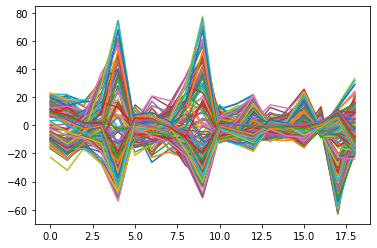

In [0]:
#X[1].plot()
from IPython.display import display

import pylab as pylab

print('Input (X) shape: ' + str(X.shape))
print('Preview of data. First slice of unfiltered data')
for el in X[1][0]:
  #print(el)
  #pylab.scatter(x=range(len(el)), y=el)
  pylab.plot(el)


In [0]:
# create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')



In [0]:
# get a list of randomly selected sets of numbers based on a range
# the proportion of values selected for each set is determined by the ratio_array
def get_mixed_indexes_for_ml_train_test(length, ratios_array):
    input_indexes = range(0, length)
    output_indexes = []
    for ratio in ratios_array:
        selection = random.choices(input_indexes, k=math.floor(ratio * length))
        input_indexes = [i for i in input_indexes if i not in selection]
        output_indexes.append(selection)
    return output_indexes
    



In [0]:

kern_len = 5
kernels, chans, samples = 1, 19, time_window/kern_len
full_size = len(X)
train_idxs, validate_idxs, test_idxs = get_mixed_indexes_for_ml_train_test(len(X), [.70, 0.15, 0.15])



X_train      = X[train_idxs][0:,]
Y_train      = np.asarray(y)[train_idxs]
X_validate   = X[validate_idxs][0:,]
Y_validate   = np.asarray(y)[validate_idxs]
X_test       = X[test_idxs][0:,]
Y_test       = np.asarray(y)[test_idxs]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
Y_test       = np_utils.to_categorical(Y_test, num_classes=2)


tw_mod = math.floor(time_window/kern_len)
X_train      = X_train.reshape(X_train.shape[0],  chans, tw_mod,   kern_len)
X_validate   = X_validate.reshape( X_validate.shape[0], chans, tw_mod, kern_len)
X_test       = X_test.reshape( X_test.shape[0], chans, tw_mod, kern_len)


 
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



#LSTM(samles, time_steps=20, input_size=30, chans)
#model = LSTM(samples=samples, time_steps=time_window, chans=chans, nb_features=1, nb_classes=2, )

print('tw_mod: ', tw_mod)
model = LeNet(samples=samples, time_steps=time_window/kern_len, chans=chans, nb_features=1, nb_classes=2 )
model.summary()

#import tensorflow 
import tensorflow.keras.optimizers
opt_adam = tensorflow.keras.optimizers.Adam(lr=0.000001, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = tensorflow.keras.optimizers.SGD(lr=0.01)



def rmse (y_true, y_pred):

    return K.sqrt(K.mean(K.square(y_pred -y_true)))

def rmse_np (y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred=y_pred.astype(int)
    print(y_pred.dtype)
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, 
              metrics=[#'mse', 'mae', 
                  'accuracy', rmse
                 ])


# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/LSTM_checkpoint.h5', verbose=1,
                               save_best_only=True)


X_train shape: (75, 19, 25, 5)
75 train samples
16 test samples
tw_mod:  25
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1 (Conv2D)            (None, 6, 8, 6)           276       
_________________________________________________________________
activation_124 (Activation)  (None, 6, 8, 6)           0         
_________________________________________________________________
average_pooling2d_40 (Averag (None, 3, 4, 6)           0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 1, 1, 16)          880       
_________________________________________________________________
activation_125 (Activation)  (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 16)                0         
___________________________________________

In [0]:

import tensorflow.keras.backend as K
#import tensorflow.keras.callbacks.LearningRateScheduler
#import tensorflow.keras.callbacks.LearningRateScheduler
def scheduler(epoch):
  if epoch == 700:
    K.set_value(model.optimizer.lr, 0.0000001)
  if epoch == 1000:
    K.set_value(model.optimizer.lr, 0.00000009)
  if epoch == 1200:
    K.set_value(model.optimizer.lr, 0.000000007)
 
  return K.get_value(model.optimizer.lr)


change_lr = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)


fitted_model = model.fit(X_train, Y_train, batch_size = 8, epochs = 800, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer, change_lr])



Train on 75 samples, validate on 16 samples
Epoch 1/800

Epoch 00001: val_loss improved from inf to 0.80804, saving model to /tmp/LSTM_checkpoint.h5
75/75 - 1s - loss: 0.7215 - acc: 0.5333 - rmse: 0.5124 - val_loss: 0.8080 - val_acc: 0.5000 - val_rmse: 0.5345
Epoch 2/800

Epoch 00002: val_loss improved from 0.80804 to 0.80766, saving model to /tmp/LSTM_checkpoint.h5
75/75 - 0s - loss: 0.7212 - acc: 0.5333 - rmse: 0.5131 - val_loss: 0.8077 - val_acc: 0.5000 - val_rmse: 0.5339
Epoch 3/800

Epoch 00003: val_loss improved from 0.80766 to 0.80730, saving model to /tmp/LSTM_checkpoint.h5
75/75 - 0s - loss: 0.7207 - acc: 0.5333 - rmse: 0.5119 - val_loss: 0.8073 - val_acc: 0.5000 - val_rmse: 0.5351
Epoch 4/800

Epoch 00004: val_loss improved from 0.80730 to 0.80695, saving model to /tmp/LSTM_checkpoint.h5
75/75 - 0s - loss: 0.7203 - acc: 0.5333 - rmse: 0.5149 - val_loss: 0.8070 - val_acc: 0.5000 - val_rmse: 0.5355
Epoch 5/800

Epoch 00005: val_loss improved from 0.80695 to 0.80659, saving mode

In [0]:
# load optimal weights
model.load_weights('/tmp/LSTM_checkpoint.h5')



probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))



Classification accuracy: 0.625000 


In [0]:
# list all data in history
#print(fitted_model.history.keys())

print('Diagrammed History of Model Metrics')

# summarize history for accuracy
plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('Model Accuracy over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [0]:
# summarize history for rmse
plt.plot(fitted_model.history['rmse'])
plt.plot(fitted_model.history['val_rmse'])
plt.title('Model RMSE over Epochs')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
# summarize loss history
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
!pip freeze

In [0]:
from platform import python_version

print(python_version())